# 04_04_hdf5.ipynb - Scientific datasets with HDF5 

In [4]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as pp
import matplotlib.mlab as mlab

import h5py

In [5]:
# if you don't have the hdf5 files from 04_02_web, 
# you can find them in the folder cache
h1file = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r')

In [6]:
h1file

<HDF5 file "H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5" (mode r)>

In [7]:
h1file.visititems(print)

meta <HDF5 group "/meta" (8 members)>
meta/Description <HDF5 dataset "Description": shape (), type "|O">
meta/DescriptionURL <HDF5 dataset "DescriptionURL": shape (), type "|O">
meta/Detector <HDF5 dataset "Detector": shape (), type "|O">
meta/Duration <HDF5 dataset "Duration": shape (), type "<i8">
meta/GPSstart <HDF5 dataset "GPSstart": shape (), type "<i8">
meta/Observatory <HDF5 dataset "Observatory": shape (), type "|O">
meta/Type <HDF5 dataset "Type": shape (), type "|O">
meta/UTCstart <HDF5 dataset "UTCstart": shape (), type "|O">
quality <HDF5 group "/quality" (3 members)>
quality/detail <HDF5 group "/quality/detail" (0 members)>
quality/injections <HDF5 group "/quality/injections" (3 members)>
quality/injections/InjDescriptions <HDF5 dataset "InjDescriptions": shape (5,), type "|S29">
quality/injections/InjShortnames <HDF5 dataset "InjShortnames": shape (5,), type "|S17">
quality/injections/Injmask <HDF5 dataset "Injmask": shape (32,), type "<u4">
quality/simple <HDF5 group "/

In [8]:
h1file.keys()

<KeysViewHDF5 ['meta', 'quality', 'strain']>

In [9]:
h1file['meta']['Description'][()]

b'Strain data time series from LIGO'

In [10]:
h1file['meta/UTCstart'][()]

b'2015-09-14T09:50:30'

In [11]:
h1file['meta/GPSstart'][()]

1126259447

In [12]:
h1strain = h1file['strain/Strain']

In [13]:
h1strain

<HDF5 dataset "Strain": shape (131072,), type "<f8">

In [14]:
h1strain[:10]

array([9.06730891e-21, 2.01178871e-20, 3.71290472e-20, 2.09071166e-20,
       1.15986367e-20, 2.07387669e-20, 3.18222310e-20, 3.12837122e-20,
       1.26644269e-20, 1.79316800e-20])

In [15]:
h1attrs = h1file['strain/Strain'].attrs

In [16]:
h1attrs

<Attributes of HDF5 object at 140603998416624>

In [17]:
dict(h1attrs)

{'Npoints': 131072,
 'Xlabel': b'GPS time',
 'Xspacing': 0.000244140625,
 'Xstart': 1126259447,
 'Xunits': b'second',
 'Ylabel': b'Strain',
 'Yunits': b''}

In [18]:
gpstime = h1attrs['Xstart'] + h1attrs['Xspacing'] * np.arange(h1attrs['Npoints'])

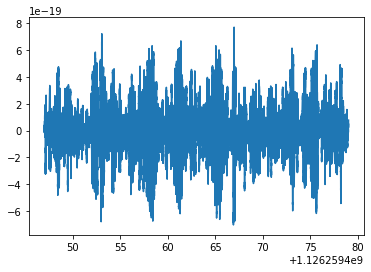

In [19]:
pp.plot(gpstime, h1strain)

In [20]:
tevent = 1126259462.4

In [21]:
around = (gpstime > tevent - 0.1) & (gpstime < tevent + 0.1)

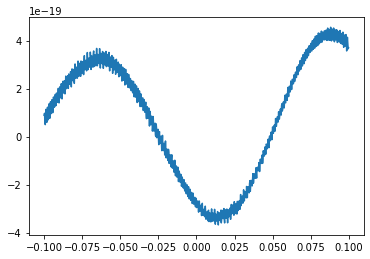

In [22]:
pp.plot(gpstime[around] - tevent, h1strain[around])

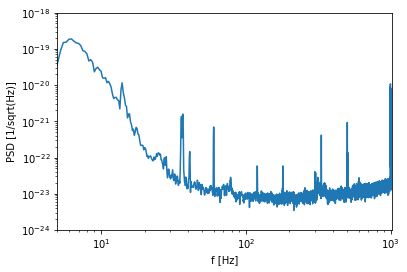

In [23]:
psd, freqs = mlab.psd(h1strain,
                      NFFT=4096*4,  # use four seconds of data to compute the spectrum
                      Fs=4096)      # this is the sampling rate of the data in Hz

pp.loglog(freqs, np.sqrt(psd))      # plot the sqrt of spectrum (power spectral density)

pp.xlabel('f [Hz]'); pp.ylabel('PSD [1/sqrt(Hz)]')
pp.axis(xmin=5, xmax=1024, ymin=1e-24, ymax=1e-18);

In [24]:
def whiten(strain, sampling=4096, bandpass=[20,350]):
    # compute the spectrum
    psd, psd_freqs = mlab.psd(strain, NFFT=sampling*4, Fs=sampling)

    # max out the spectrum outside the bandpass
    psd[(psd_freqs < bandpass[0]) | (psd_freqs > bandpass[1])] = np.max(psd)
    
    dt = 1/sampling

    # compute the real FFT and the corresponding frequencies
    strain_fft = np.fft.rfft(strain)
    fft_freqs = np.fft.rfftfreq(len(strain), dt)

    # interpolate the spectrum to the FFT frequencies
    psd_fft = scipy.interpolate.interp1d(psd_freqs, psd)(fft_freqs)
    
    # whiten and transform back to real space
    whitened = np.fft.irfft(strain_fft / np.sqrt(psd_fft) * np.sqrt(2*dt))
    
    return whitened

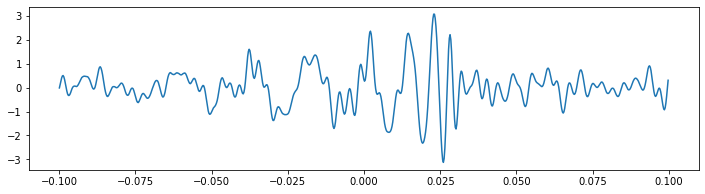

In [25]:
pp.figure(figsize=(12,3))
pp.plot(gpstime[around] - tevent, whiten(h1strain)[around])

In [26]:
l1file = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r')

In [27]:
l1strain = l1file['strain/Strain']

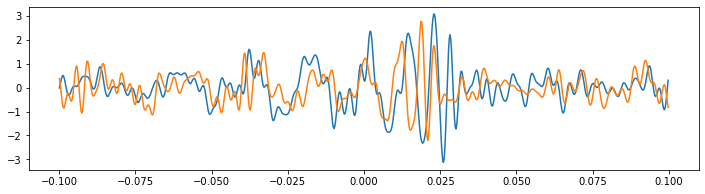

In [28]:
pp.figure(figsize=(12,3))
pp.plot(gpstime[around] - tevent, whiten(h1strain)[around])
pp.plot(gpstime[around] - tevent, whiten(l1strain)[around])

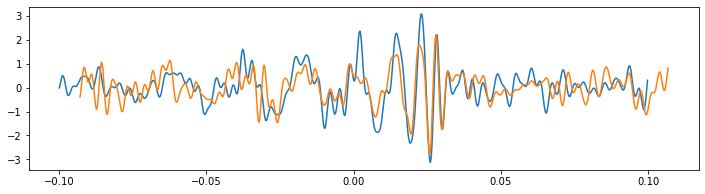

In [29]:
pp.figure(figsize=(12,3))
pp.plot(gpstime[around] - tevent, whiten(h1strain)[around])
pp.plot(gpstime[around] - tevent + 0.007, -whiten(l1strain)[around])